In [1]:
import findspark
findspark.add_packages("org.mongodb.spark:mongo-spark-connector_2.12:2.4.2")

In [2]:
import os
import pyspark
from dotenv import dotenv_values

# Retrieve MongoDB creds
config = dotenv_values("creds.env")

user = config['user']
password = config['password']

db = "gfw"

# Connect to MongoDB
uri = "mongodb+srv://" + user + ":" + password + "@cluster0.6jfc5iw.mongodb.net/"

# Start Spark session
conf = pyspark.SparkConf() \
.set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:2.4.2") \
.setMaster("local") \
.setAppName("My app") \
.setAll([("spark.driver.memory", "5g"), ("spark.executor.memory", "6g")])

sc = pyspark.SparkContext(conf=conf)

spark = pyspark.sql.SparkSession(sc)
spark

:: loading settings :: url = jar:file:/Users/erinmiller/Library/Python/3.9/lib/python/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/erinmiller/.ivy2/cache
The jars for the packages stored in: /Users/erinmiller/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9a37d556-13cb-406e-9fce-3ec1e74014b7;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;2.4.2 in central
	found org.mongodb#mongo-java-driver;3.12.5 in central
:: resolution report :: resolve 239ms :: artifacts dl 15ms
	:: modules in use:
	org.mongodb#mongo-java-driver;3.12.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;2.4.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   

In [3]:
# counts = {}
# counts = {'Belgian Exclusive Economic Zone2012': 0, 'Belgian Exclusive Economic Zone2013': 6151, 'Belgian Exclusive Economic Zone2014': 7682, 'Belgian Exclusive Economic Zone2015': 7492, 'Belgian Exclusive Economic Zone2016': 9618, 'Belgian Exclusive Economic Zone2017': 12192, 'Belgian Exclusive Economic Zone2018': 10922, 'Belgian Exclusive Economic Zone2019': 9031, 'Belgian Exclusive Economic Zone2020': 9434, 'Latvian Exclusive Economic Zone2012': 0, 'Latvian Exclusive Economic Zone2013': 1538}

In [19]:
# Get count of fishing events in a given country/year
country = "Estonian Exclusive Economic Zone"
year = 2020
pipeline = [
    { "$match": { "country": country, "year": year } }
]

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option('uri', uri) \
    .option('database', db) \
    .option('collection', 'gfw') \
    .option('pipeline', pipeline) \
    .option('allowDiskUse', 'true') \
    .load()

counts[country + str(year)] = df.count()

In [46]:
# df.show()
# df.count()
# print(counts)
from pyspark.sql.functions import split, when
converterDict = {"Belgian": "Belgium", "Latvian": "Latvia", "Estonian": "Estonia"}
countsDF = spark.createDataFrame([(k, v) for k, v in counts.items()], ['id', 'dict_value'])
# Fix country and year columns
countsDF = countsDF.withColumn('Country', split(countsDF['id'], '\s+')[0])
countsDF = countsDF.withColumn('Year', split(countsDF['id'], '\s+')[3].substr(5, 8))
for old, new in converterDict.items():
    countsDF = countsDF.withColumn('Country', when(countsDF['Country'] == old, new).otherwise(countsDF['Country']))
countsDF.show(100)

+--------------------+----------+-------+----+
|                  id|dict_value|Country|Year|
+--------------------+----------+-------+----+
|Belgian Exclusive...|         0|Belgium|2012|
|Belgian Exclusive...|      6151|Belgium|2013|
|Belgian Exclusive...|      7682|Belgium|2014|
|Belgian Exclusive...|      7492|Belgium|2015|
|Belgian Exclusive...|      9618|Belgium|2016|
|Belgian Exclusive...|     12192|Belgium|2017|
|Belgian Exclusive...|     10922|Belgium|2018|
|Belgian Exclusive...|      9031|Belgium|2019|
|Belgian Exclusive...|      9434|Belgium|2020|
|Latvian Exclusive...|         0| Latvia|2012|
|Latvian Exclusive...|      1538| Latvia|2013|
|Latvian Exclusive...|      3040| Latvia|2014|
|Latvian Exclusive...|      3811| Latvia|2015|
|Latvian Exclusive...|      3207| Latvia|2016|
|Latvian Exclusive...|      4254| Latvia|2017|
|Latvian Exclusive...|      4722| Latvia|2018|
|Latvian Exclusive...|      3716| Latvia|2019|
|Latvian Exclusive...|      3597| Latvia|2020|
|Estonian Exc

In [100]:
# Get tourism data for all countries/years
countries = ["Belgium", "Latvia", "Estonia"]
years = ["2013 [YR2013]", "2014 [YR2014]", "2015 [YR2015]", "2016 [YR2016]", "2017 [YR2017]", "2018 [YR2018]", "2019 [YR2019]", "2020 [YR2020]"]

pipeline = [
    { "$match": { "Country Name": { "$in": countries }, "Year": { "$in": years } } }
]

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option('uri', uri) \
    .option('database', db) \
    .option('collection', 'tourism') \
    .option('pipeline', pipeline) \
    .option('allowDiskUse', 'true') \
    .load()
# Fix up cols for consistent naming
df = df.withColumnRenamed("Country Name", "Country")
df = df.withColumn("Year", df["Year"].substr(0, 4))
# Join df with countsDF
df = df.join(countsDF, ["Country", "Year"], "inner")
# Remove Estonia 2020
df = df.filter((df.Country != "Estonia") | (df.Year != "2020"))
df.show(100)

+-------+----+--------+------------+-----------------+-----------+--------------------+--------------------+----------+
|Country|Year|Arrivals|Country Code|              GDP|   Receipts|                 _id|                  id|dict_value|
+-------+----+--------+------------+-----------------+-----------+--------------------+--------------------+----------+
|Belgium|2013| 7684000|         BEL|0.459242192907709|14534000000|{64591b0bf8c148fb...|Belgian Exclusive...|      6151|
|Belgium|2014| 7887000|         BEL| 1.57853314322614|15249000000|{64591b0bf8c148fb...|Belgian Exclusive...|      7682|
|Belgium|2015| 8355000|         BEL| 2.04145900919961| 8975000000|{64591b0bf8c148fb...|Belgian Exclusive...|      7492|
|Belgium|2016| 7481000|         BEL| 1.26668640902095| 8784000000|{64591b0bf8c148fb...|Belgian Exclusive...|      9618|
|Belgium|2017| 8385000|         BEL|  1.6195802783878| 9636000000|{64591b0bf8c148fb...|Belgian Exclusive...|     12192|
|Belgium|2018| 9119000|         BEL| 1.7

In [101]:
# Check for correlation between dict_val (number of fishing events) and GDP, Arrivals
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.stat import Correlation
# Convert Arrivals, Receipts, GDP, dict_value to numeric
df = df.withColumn("Arrivals", df["Arrivals"].cast("int"))
df = df.withColumn("Receipts", df["Receipts"].cast("int"))
# Cast GDP to float
df = df.withColumn("GDP", df["GDP"].cast("double"))
df = df.withColumn("dict_value", df["dict_value"].cast("int"))
df.show(100)
print("Fishing Events Correlation to GDP: " + str(df.stat.corr('dict_value', 'GDP')))
# print("Fishing Events Correlation to Receipts: " + str(df.stat.corr('dict_value', 'Receipts')))
print("Fishing Events Correlation to Arrivals: " + str(df.stat.corr('dict_value', 'Arrivals')))

+-------+----+--------+------------+-----------------+----------+--------------------+--------------------+----------+
|Country|Year|Arrivals|Country Code|              GDP|  Receipts|                 _id|                  id|dict_value|
+-------+----+--------+------------+-----------------+----------+--------------------+--------------------+----------+
|Belgium|2013| 7684000|         BEL|0.459242192907709|      null|{64591b0bf8c148fb...|Belgian Exclusive...|      6151|
|Belgium|2014| 7887000|         BEL| 1.57853314322614|      null|{64591b0bf8c148fb...|Belgian Exclusive...|      7682|
|Belgium|2015| 8355000|         BEL| 2.04145900919961|      null|{64591b0bf8c148fb...|Belgian Exclusive...|      7492|
|Belgium|2016| 7481000|         BEL| 1.26668640902095|      null|{64591b0bf8c148fb...|Belgian Exclusive...|      9618|
|Belgium|2017| 8385000|         BEL|  1.6195802783878|      null|{64591b0bf8c148fb...|Belgian Exclusive...|     12192|
|Belgium|2018| 9119000|         BEL| 1.792945193

[ 0.45924219  1.57853314  2.04145901  1.26668641  1.61958028  1.79294519
  2.24085824 -5.36138663  1.45842864  3.01136659  1.85302005  3.15556481
  5.79204467  3.78420085  3.73970668  2.00796688  1.90217268  3.88526005
  2.36861475  3.31247594  3.9918545   2.56970389 -2.20298534]


Text(0, 0.5, 'Number of Fishing Events')

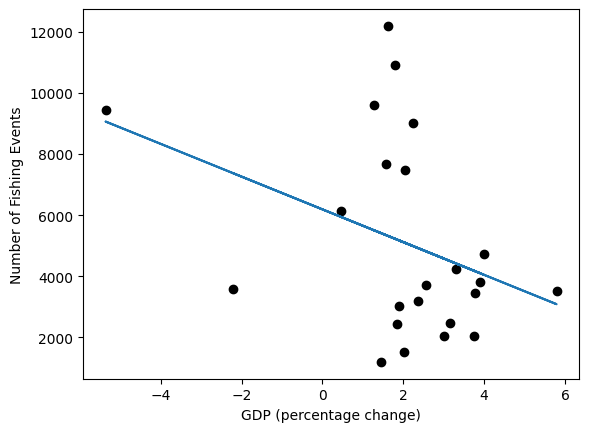

In [102]:
# Use matplotlib to plot fishing events vs GDP, Arrivals, Receipts
import matplotlib.pyplot as plt
import numpy as np
import pandas

# GDP -- color the dots according to country and have a legend
# x = df.select("GDP").toPandas().to_numpy()
# y = df.select("dict_value").toPandas().to_numpy()
x = df.select("GDP").toPandas().to_numpy().flatten()
y = df.select("dict_value").toPandas().to_numpy().flatten()
print(x)
# plt.scatter(x, y, c=df.select("Country").toPandas().to_numpy().flatten())
plt.scatter(x, y, c="black")
# print(x)

m, b = np.polyfit(np.array(x), np.array(y), 1)
plt.plot(x, m*x + b)
# Label the axes
plt.xlabel("GDP (percentage change)")
plt.ylabel("Number of Fishing Events")
# plt.scatter(x, y)

+-------+----+--------+------------+-----------------+----------+--------------------+--------------------+----------+
|Country|Year|Arrivals|Country Code|              GDP|  Receipts|                 _id|                  id|dict_value|
+-------+----+--------+------------+-----------------+----------+--------------------+--------------------+----------+
|Belgium|2013| 7684000|         BEL|0.459242192907709|      null|{64591b0bf8c148fb...|Belgian Exclusive...|      6151|
|Belgium|2014| 7887000|         BEL| 1.57853314322614|      null|{64591b0bf8c148fb...|Belgian Exclusive...|      7682|
|Belgium|2015| 8355000|         BEL| 2.04145900919961|      null|{64591b0bf8c148fb...|Belgian Exclusive...|      7492|
|Belgium|2016| 7481000|         BEL| 1.26668640902095|      null|{64591b0bf8c148fb...|Belgian Exclusive...|      9618|
|Belgium|2017| 8385000|         BEL|  1.6195802783878|      null|{64591b0bf8c148fb...|Belgian Exclusive...|     12192|
|Belgium|2018| 9119000|         BEL| 1.792945193

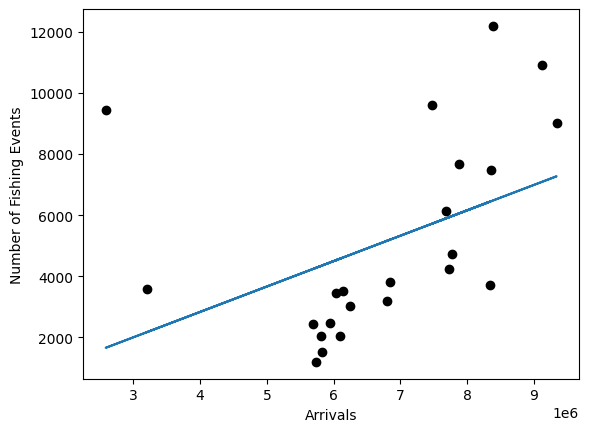

In [103]:
# Plot for arrivals
x = df.select("Arrivals").toPandas().to_numpy().flatten()
# y = df.select("dict_value").toPandas().to_numpy().flatten()
plt.scatter(x, y, c="black")
m, b = np.polyfit(np.array(x), np.array(y), 1)
plt.xlabel("Arrivals")
plt.ylabel("Number of Fishing Events")
plt.plot(x, m*x + b)
df.show()

+-------+----+--------+------------+----------------+----------+--------------------+--------------------+----------+
|Country|Year|Arrivals|Country Code|             GDP|  Receipts|                 _id|                  id|dict_value|
+-------+----+--------+------------+----------------+----------+--------------------+--------------------+----------+
|Estonia|2013| 5737000|         EST|1.45842863615992|2022000000|{64591b0bf8c148fb...|Estonian Exclusiv...|      1198|
|Estonia|2015| 5696000|         EST|1.85302004629342|1893000000|{64591b0bf8c148fb...|Estonian Exclusiv...|      2434|
|Estonia|2016| 5942000|         EST|3.15556481438308|1911000000|{64591b0bf8c148fb...|Estonian Exclusiv...|      2470|
|Estonia|2017| 6145000|         EST|5.79204467466494|2124000000|{64591b0bf8c148fb...|Estonian Exclusiv...|      3521|
+-------+----+--------+------------+----------------+----------+--------------------+--------------------+----------+



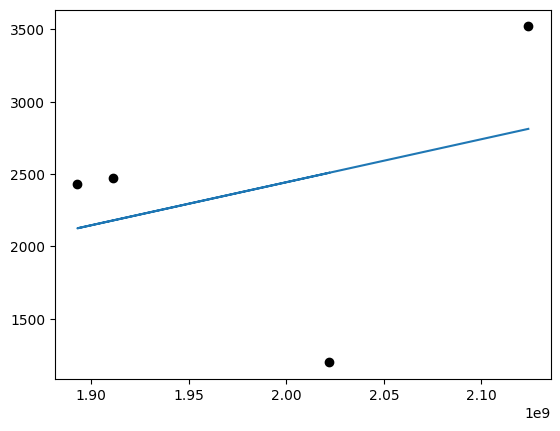

In [97]:
# Remove from df if receipts is null
df = df.filter(df.Receipts.isNotNull())
# Plot for receipts
df.show()
x = df.select("Receipts").toPandas().to_numpy().flatten()
y = df.select("dict_value").toPandas().to_numpy().flatten()
plt.scatter(x, y, c="black")
m, b = np.polyfit(np.array(x), np.array(y), 1)
plt.plot(x, m*x + b)

